## Physical modeling

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d

# make a directory for figures
!mkdir figures

from os.path import basename, exists
def download(url):
    fileName = basename(url)
    if not exists(fileName):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, fileName)
        print(f'Downloaded {local}')

download('https://github.com/wernadsky/test/raw/master/cell2d.py')
download('https://github.com/wernadsky/test/raw/master/utils.py')

from cell2d import Cell2D, draw_array, add_island, multi_frame, three_frame

A subdirectory or file figures already exists.


Downloaded utils.py


### Diffusion

In [3]:
class Diffusion(Cell2D):
    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]])
    
    def __init__(self, n, rate=0.1):
        # n: number of rows
        # r: diffusion rate constant
        self.rate = rate
        self.array = np.zeros((n, n), float)
    
 
    def step(self):
        c = correlate2d(self.array, self.kernel, mode='same', boundary='wrap')
        self.array += self.rate * c
    
    def draw(self, size=None):
        return draw_array(self.array, size, cmap='Greens')

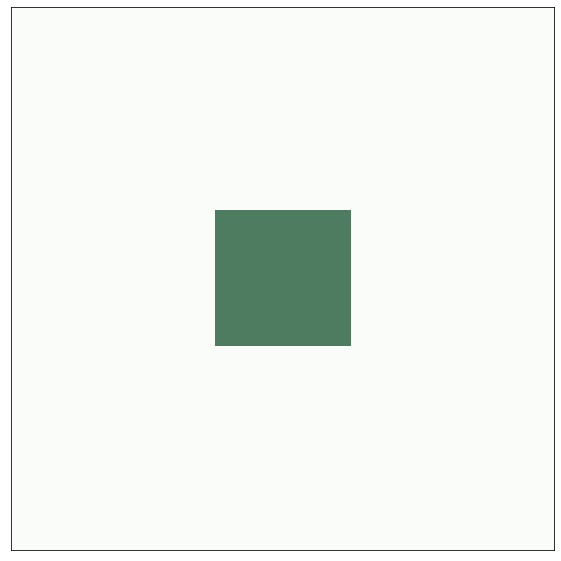

In [4]:
diff = Diffusion(n=16, rate=0.1)
add_island(diff.array, size=4)
fig = diff.draw(10)

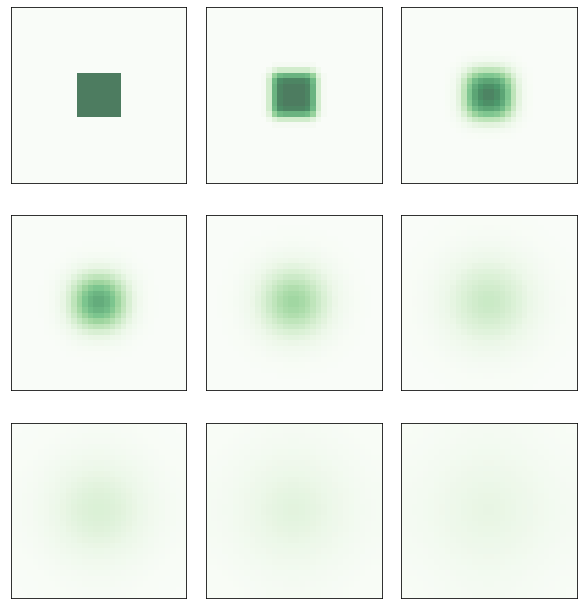

In [5]:
diff = Diffusion(n=32, rate=0.2)
add_island(diff.array, size=8)
fig = multi_frame(diff, [0, 2, 5, 10, 20, 30, 30, 30, 30])
fig.set_size_inches(9, 9)
fig.savefig('images/multi_frames')

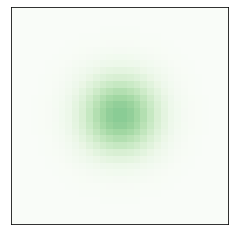

In [6]:
diff = Diffusion(n=32, rate=0.2)
add_island(diff.array, size=8)
fig = diff.animate(frames=30, size=4, interval=0.1)
fig.set_size_inches(12, 12)
fig.tight_layout()
fig.savefig('images/diffusion')

### Reaction-Diffusion
For the RD model, we have two arrays, one for each chemical.

Following [Sims](http://www.karlsims.com/rd.html), I'm using a kernel that includes the diagonal elements.  They have lower weights because they are farther from the center cell.

The `step` function computes these functions:

$\Delta A = r_a \nabla^2 A - AB^2 + f (1-A) $

$\Delta B = r_b \nabla^2 B + AB^2 - (k+f) B $

where $\nabla^2$ is the Laplace operator the kernel is intended to approximate.

In [138]:
class ReactionDiffusion(Diffusion):
    kernel = np.array([[.05, .2, .05],
                       [ .2, -1, .2],
                       [.05, .2, .05]])

    def __init__(self, n, params, noise=0.1):
        """
        n: number of rows
        params: tuple of (rateA, rateB, feed, kill)
        """

        self.params = params
        self.arrayA = np.ones((n, n), dtype=float)
        self.arrayB = noise * np.random.random((n, n))
        add_island(self.arrayB, size=n//10, height=0.1, noise=noise)

    def step(self):
        A, B = self.arrayA, self.arrayB
        rA, rB, f, k = self.params  # rateA, rateB, feed, kill
        options = dict(mode='same', boundary='wrap')
        cA = correlate2d(A, self.kernel, **options)
        cB = correlate2d(B, self.kernel, **options)
        reaction = A * B**2
        self.arrayA += rA * cA - reaction + f * (1-A) 
        self.arrayB += rB * cB + reaction - (f+k) * B


    def draw(self, size=None):
        """Draws the cells."""
        options = dict(interpolation='bicubic', 
                       vmin=None, vmax=None)
        draw_array(self.arrayA, size, cmap='Reds', **options)
        draw_array(self.arrayB, size, cmap='Blues', **options)

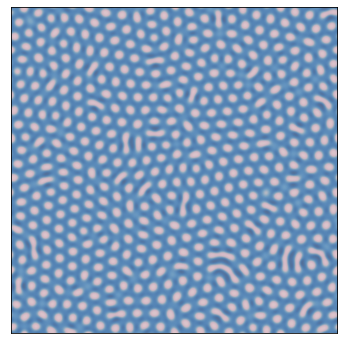

In [140]:
params1 = 0.5, 0.25, 0.035, 0.057   # pink spots and stripes
params2 = 0.5, 0.25, 0.055, 0.062   # coral
params3 = 0.5, 0.25, 0.039, 0.065   # blue spots

rd1 = ReactionDiffusion(n=300, params=params1)
fig = rd1.animate(frames=150, size=6, iters=50)

In [139]:
rd2 = ReactionDiffusion(n=300, params=params2)
fig = rd2.animate(frames=150, size=6, iters=50)

NameError: name 'params2' is not defined

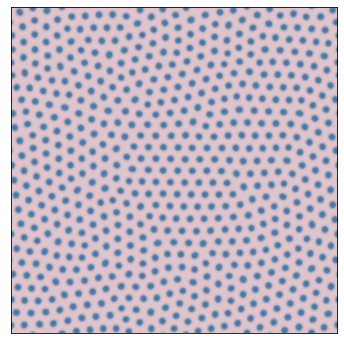

In [61]:
rd3 = ReactionDiffusion(n=300, params=params3)
fig = rd3.animate(frames=500, size=6, iters=50)

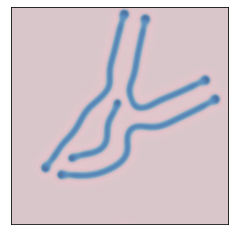

In [38]:
params4 = 0.5, 0.25, 0.05, 0.065
rd4 = ReactionDiffusion(n=150, params=params4)
fig = rd4.animate(frames=150, size=4, iters=50)

In [15]:
fig.set_size_inches(21, 21)
fig.savefig('figures/05_025_0035_0057-2')

#### Percolation

In [100]:
class Percolation(Cell2D):
    def __init__(self, n, m=None, p=.5):

        if m is None:
            m = n
        self.p = p      # вероятность того, что клетка будет порой
        self.array = np.random.choice([0, 1], (n, m), p=[1-p, p])
        # матрица nxm случайно распределенных значений 0 и 1
        # в соответствии с вероятностью p 
        self.array[0] = 5   # верхний ряд (мокрые клетки)

    kernel = np.array([ [0, 1, 0],      # на каждом шаге необходимо определять
                        [1, 0, 1],      # имеются ли у поры мокрые клетки
                        [0, 1, 0] ])    # по соседству Неймана

    def step(self):
        a = self.array
        c = correlate2d(a, self.kernel, mode='same', boundary='fill')
        self.array[(a==1) & (c>=5)] = 5

    def num_wet(self):
        """Total number of wet cells."""
        return np.sum(self.array == 5)
    
    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == 5)

    def draw(self, size=None):
        """Draws the cells."""
        draw_array(self.array, size, cmap='Blues', vmax=5)

    def test(self, mode='first'):
        """ запуск процесса перколяции; повторяет step, до тех пор пока жидкость
        не остановится или (при mode='first') пока не дойдет до дна.
        Возвращает True, если жидкость доходит до дна (т.е. существует кластер), иначе False
        """
        if mode=='first':
            first = True
        elif mode=='full':
            first = False
        else:
            raise ValueError('argument mode must be "fist" of "full"')

        num_wet = self.num_wet()
        while True:
            self.step()

            if self.bottom_row_wet() and first:
                return True

            new_num_wet = self.num_wet()
            if new_num_wet == num_wet:
                return bool(self.bottom_row_wet())
            
            num_wet = new_num_wet

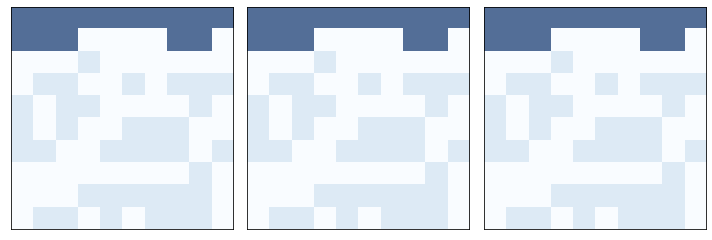

In [6]:
n = 10
p = 0.5
# np.random.seed(42)
perc = Percolation(n, p=p)

fig = three_frame(perc, [1, 5, 5])

In [60]:
perc = Percolation(500,p=0.4)
fig = perc.animate(frames=1500, size=10, interval=0.01, iters=1)

<Figure size 432x288 with 0 Axes>

False


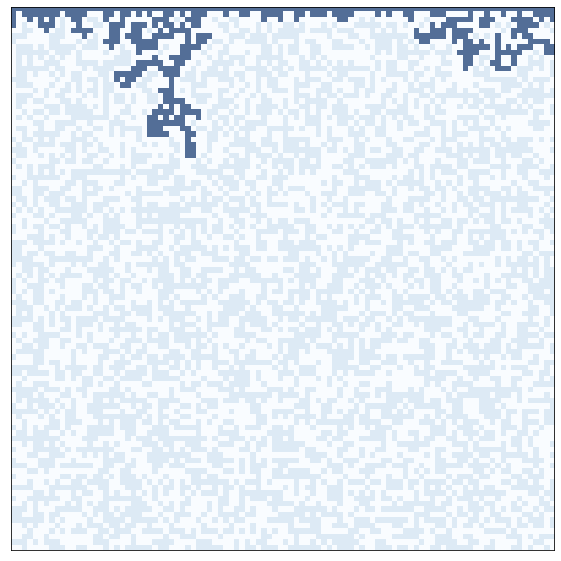

In [63]:
# np.random.seed(44)
perc = Percolation(100, p=0.5)
clusterExist = perc.test(mode='full')
perc.draw(size=10)
print(clusterExist)

In [134]:
def estimate_prob_percolation(n=50, m=None, p=None, iters=100) -> float:
    """ Оценка вероятности того, что у структуры с заданными 
        характеристиками будет кластер"""
    t = [Percolation(n, m=m, p=p).test() for i in range(1000)]
    return np.mean(t)

estimate_prob_percolation(50, p=0.59)
# можно заметить, что примерно около p=0.6 возникает резкий [фазовый] 
# переход от знчения вероятности 0 к значению 1; т.е. где-то около
# p=0.6 имеется критическое значение

0.445

Воспользуемся методом <b>random walk</b>, чтобы приблизиться к критическому значению. начнем со значения p=0.6, далее на каждой итерации будет создаваться новая структура и если в ней возникает кластер, то значение p уменьшается, а если не возникает кластер, то p уменьшается. В результате мы собираем неоторое множество значений p в списке. Далее усреднив эти значения, можем получить критическое значение (<b>критическая точка</b>). Широкий спектр систем показывают общий набор поведения и характеристик в окрестностях критической точки. Такое поведение называется <b>критическим явлением</b>. 

In [135]:
def find_critical(n=50, p=0.6, iters=100):
    ps = [p]
    for i in range(iters):
        perc = Percolation(n=n, p=p)
        if perc.test():
            p -= 0.005
        else:
            p += 0.005
        ps.append(p)
    return ps

ps = find_critical()
print(np.mean(ps[len(ps)//2:]))

0.5924509803921568
